In [1]:
# Kaggle Comprtition URL
# https://www.kaggle.com/competitions/nlp-getting-started/overview
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
dir_path = '/content/'##'./data/'

In [2]:
# Load train/test data
train_data = pd.read_csv(dir_path + 'train.csv')
test_data = pd.read_csv(dir_path + 'test.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/train.csv'

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
#see if the text is positive or negative
def get_sentiment(text):
  analysis = TextBlob(text)
  return analysis.sentiment.polarity

In [ ]:
import re
def clean(text):
  text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove URLs
  text = re.sub(r'\@|\#|\d+|[|]_-', '', text)
  text = re.sub('<.*?>', '', text) #remove HTML
  return text

In [ ]:
train_data['clean_text']=train_data['text'].apply(clean)
x_train = train_data['clean_text']
y_train = train_data['target']

#get the sentimet of the train text
#train_data['sentiment'] = train_data['text'].apply(get_sentiment) #no change
#test_data['sentiment'] = test_data['text'].apply(get_sentiment)

#get the length of both text
#train_data["text_length"] = train_data["text"].apply(len) #worse
#test_data["text_length"] = test_data["text"].apply(len)

test_data['clean_text']=test_data['text'].apply(clean)
x_test = test_data['clean_text']

train_data['text_length'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
test_data['text_length'] = test_data['text'].apply(len)
test_data['word_count'] = test_data['text'].apply(lambda x: len(x.split()))

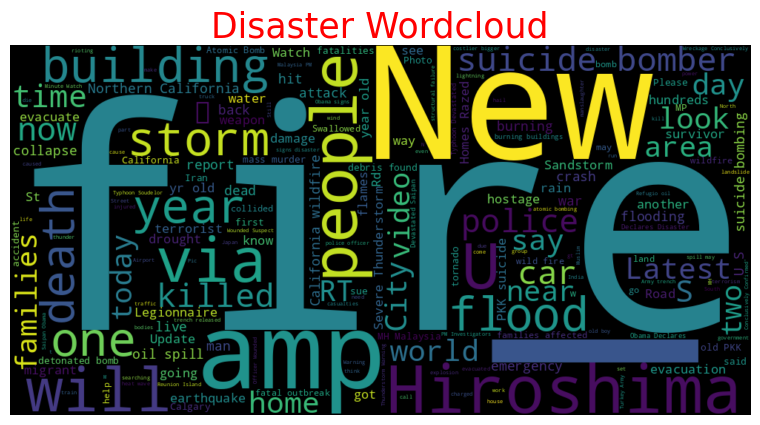

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
disaster = ' '.join(train_data[train_data['target']==1]['clean_text'])
plt.figure(figsize=(10,4))
wordcloud = WordCloud(width=1000,height=500).generate(disaster)
plt.imshow(wordcloud,interpolation='bilinear',cmap='magma')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Red')
plt.show()

In [ ]:
#ignore terms that are too frequent, remove stop words, and have ngrams
count_vectorizer = CountVectorizer(max_df=0.5,ngram_range=(1,3),stop_words='english')

x_train_vectors = count_vectorizer.fit_transform(x_train)
x_test_vectors = count_vectorizer.transform(x_test)

# Step 2: Encode 'keyword' using LabelEncoder (convert categorical to numeric)
ohe = OneHotEncoder(sparse_output=False)
train_key = ohe.fit_transform(train_data[['keyword']])
test_key = ohe.transform(test_data[['keyword']])

numeric_features_train = csr_matrix(train_data[['text_length', 'word_count']].values)
numeric_features_test = csr_matrix(test_data[['text_length', 'word_count']].values)

#combin all vectors into matrix
x_train_vectors = hstack([train_key,x_train_vectors,numeric_features_train])  #don't need this if don't use previous two
x_test_vectors = hstack([test_key,x_test_vectors,numeric_features_test])

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
Xtrain, Xtest, ytrain, ytest = train_test_split(x_train_vectors,y_train, test_size=0.33, random_state=42)
# 定義多個模型
log_reg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42, max_iter=1000,class_weight='balanced')
rg_clf = RidgeClassifier(alpha= 7, tol= 0.0001,class_weight='balanced')
xgb_clf = XGBClassifier(
    objective='binary:logistic',  # 二元分類任務
    eval_metric='logloss',       # 評估指標，可以換成 'auc' 或 'error'
    use_label_encoder=False,     # 避免警告
    n_estimators=500,            # 樹的數量
    learning_rate=0.3,           # 學習率
    max_depth=5,                 # 樹的最大深度
    random_state=42
)
tree_clf = DecisionTreeClassifier(criterion='entropy',max_depth=100,min_samples_leaf=1,min_samples_split=50,random_state=42)

# 投票分類器（軟投票）
voting_clf = VotingClassifier(
    estimators=[('log_reg', log_reg), ('tree', tree_clf), ('rg', rg_clf),('xgb',xgb_clf)],
    voting='hard',
)

# 訓練與評估
voting_clf.fit(Xtrain, ytrain)
y_pred = voting_clf.predict(Xtest)

print(f"F1分數: {f1_score(ytest, y_pred)}")
print("voting:",classification_report(ytest,y_pred))
# x_train_vectors=x_train_vectors.toarray()
# x_test_vectors=x_test_vectors.toarray()

# voting_clf.fit(x_train_vectors, y_train)
# y_pre = voting_clf.predict(x_test_vectors)
# submission_data = pd.DataFrame({'id':test_data['id'], 'target':y_pre})
# submission_data.to_csv('voting_submission.csv',index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# see if there is difference between TfidfVectorizer and CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,ngram_range=(1,3),stop_words='english')

x_tfidf_train_vectors = tfidf_vectorizer.fit_transform(x_train)
x_tfidf_test_vectors = tfidf_vectorizer.transform(x_test)

rclf = RidgeClassifier(tol=0.01)
rclf.fit(x_tfidf_train_vectors,y_train)

rclf_tfidf_prediction = rclf.predict(x_tfidf_test_vectors)

submission_data = pd.DataFrame({'id':test_data['id'], 'target':rclf_tfidf_prediction})

submission_data.to_csv('RidgeClassifier_tfidf_tol0.01_submission.csv',index=False)

Public score: 0.80324

RidgeClassifier

In [ ]:
# train the classifier to address overfitting and make predictions
rclf = RidgeClassifier()
rclf.fit(x_train_vectors,y_train)

rclf_prediction = rclf.predict(x_test_vectors)

In [ ]:
submission_data = pd.DataFrame({'id':test_data['id'], 'target':rclf_prediction})

submission_data.to_csv('RidgeClassifier_alpha7_submission.csv',index=False)

Public score: 0.79344

LogisticRegression

In [ ]:
from sklearn import linear_model

logr = linear_model.LogisticRegression()
logr.fit(x_train_vectors,y_train)
logr_prediction = logr.predict(x_test_vectors)

In [ ]:
submission_data = pd.DataFrame({'id':test_data['id'], 'target':logr_prediction})

submission_data.to_csv('LogisticRegression_submission.csv',index=False)

In [ ]:
#testing different ways of regularization in LogisticRegression (reduce error and overfitting)
l1_model = linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42, max_iter=1000)
l2_model = linear_model.LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42, max_iter=1000)  #defult setting max_iter=1000 making it perform better than original
#elastic_net_model = linear_model.LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, random_state=42)

# Train the model
l1_model.fit(x_train_vectors,y_train)
l2_model.fit(x_train_vectors,y_train)
#elastic_net_model.fit(x_train_vectors,y_train)

l1_model_pre = l1_model.predict(x_test_vectors)
l2_model_pre = l2_model.predict(x_test_vectors)
#elastic_net_model_pre = elastic_net_model.predict(x_test_vectors)

submission_data = pd.DataFrame({'id':test_data['id'], 'target':l1_model_pre})
submission_data.to_csv('LogrL1_submission.csv',index=False)

submission_data = pd.DataFrame({'id':test_data['id'], 'target':l2_model_pre})
submission_data.to_csv('LogrL2_submission.csv',index=False)

#submission_data = pd.DataFrame({'id':test_data['id'], 'target':elastic_net_model_pre})
#submission_data.to_csv('Logr_elastic_submission.csv',index=False)



1. L1 Public score: 0.79313
2. L2 Public score: 0.80110
3. Elastic_net_model Public score: 0.79865
4. L1_tfidf Public score: 0.76739
5. L2_tfidf Public score: 0.80110

Random Forest Regression

In [ ]:
#not good with dealing large data!
from sklearn.ensemble import RandomForestRegressor
# Initialize the RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(x_train_vectors, y_train)  #too large cannot work
rf_prediction=rf.predict(x_test_vectors)

submission_data = pd.DataFrame({'id':test_data['id'], 'target':rf_prediction})
submission_data.to_csv('RandomForest_submission.csv',index=False)

from sklearn.metrics import mean_squared_error, r2_score
# Evaluation
print("MSE:", mean_squared_error(y_train, rf_prediction))
print("R² Score:", r2_score(y_train, rf_prediction))

# check accuracy #

In [ ]:
#Check the accuracy score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

y = train_data['target']

# Split the data into training and testing sets
# y_test is the true labels and y_pred are the model's predictions
X_train, X_val, y_train, y_test = train_test_split(x_tfidf_train_vectors, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
#rclf = linear_model.LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42, max_iter=1000)
rclf.fit(X_train, y_train)

# our prediction
y_pred = rclf.predict(X_val)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.8782608695652174
Recall: 0.6224961479198767
F1 Score: 0.7285843101893598


Precision: 0.8217054263565892
Recall: 0.6533127889060092
F1 Score: 0.7278969957081545

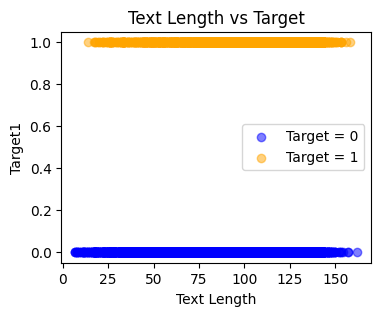

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot with different colors for target1 values
plt.figure(figsize=(4, 3))

plt.scatter(train_data[train_data['target'] == 0]['text_length'],
      train_data[train_data['target'] == 0]['target'],
      color='blue', alpha=0.5, label='Target = 0')
plt.scatter(train_data[train_data['target'] == 1]['text_length'],
      train_data[train_data['target'] == 1]['target'],
      color='orange', alpha=0.5, label='Target = 1')

plt.title('Text Length vs Target')
plt.xlabel('Text Length')
plt.ylabel('Target1')
plt.legend()
plt.show()

In [ ]:
# Compute the correlation matrix
correlation = train_data[['text_length', 'sentiment', 'sentiment', 'target']].corr()
print(correlation)

             text_length  sentiment  sentiment    target
text_length     1.000000   0.034057   0.034057  0.181667
sentiment       0.034057   1.000000   1.000000 -0.096567
sentiment       0.034057   1.000000   1.000000 -0.096567
target          0.181667  -0.096567  -0.096567  1.000000


In [ ]:
# Access the coefficients after training
feature_importance = clf.coef_[0]

# Get feature names from the CountVectorizer
vectorizer_features = count_vectorizer.get_feature_names_out()

# Combine all feature names (vectorizer features + other numerical features)
# Assuming the order is [vectorizer features, text length, sentiment]
all_feature_names = list(vectorizer_features) + ['text_length', 'sentiment']

import pandas as pd

# Create a DataFrame with feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance
})

# Sort features by their absolute importance
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Importance'].abs().sort_values(ascending=False).index)

# Display the top features
print(feature_importance_df)

import matplotlib.pyplot as plt

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)  # Adjust the number of features to display as needed
plt.barh(top_features['Feature'], top_features['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Top Features Influencing Target1')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()


ValueError: All arrays must be of the same length